In [45]:
import glob
import time
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from scipy import misc
%matplotlib inline

In [40]:
images = glob.glob('non-vehicles/Extras/*.png')
images1 = glob.glob('non-vehicles/GTI/*.png')
images2 = glob.glob('vehicles/KITTI_extracted/*.png')
cars = []
notcars = []

for image in images:
    notcars.append(image)
    
for image in images2:
    cars.append(image)

cars = cars[:1]
notcars = notcars[:1]


In [72]:
colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"

['vehicles/KITTI_extracted\\1.png']
['non-vehicles/Extras\\extra1.png']


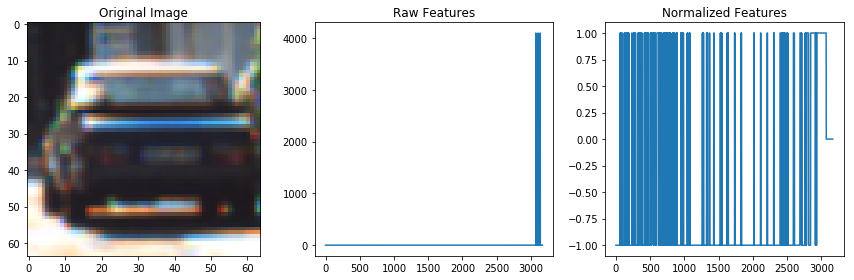

In [42]:
car_features = extract_features(cars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

In [62]:
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [18]:

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    #return rhist, ghist, bhist, bin_centers, hist_features
    return hist_features
    



In [13]:
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

(3072,)


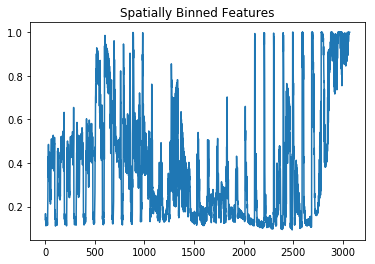

In [15]:
feature_vec = bin_spatial(car_image, color_space='RGB', size=(32, 32))

# Plot features
plt.plot(feature_vec)
plt.title('Spatially Binned Features')
print(feature_vec.shape)

In [16]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=True,
                     feature_vec=True):
                         
    """
    Function accepts params and returns HOG features (optionally flattened) and an optional matrix for 
    visualization. Features will always be the first return (flattened if feature_vector= True).
    A visualization matrix will be the second return if visualize = True.
    """
    
    return_list = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys', transform_sqrt=False, 
                                  visualise= vis, feature_vector= feature_vec)
    
    # name returns explicitly
    hog_features = return_list[0]
    if vis:
        hog_image = return_list[1]
        return hog_features, hog_image
    else:
        return hog_features

In [71]:
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    print (imgs)
    for file in imgs:
        #print (file)
        # Read in each one by one  
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))

        # Append the new feature vector to the features list
        features.append(hog_features)
        # Return list of feature vectors
    return features


In [63]:
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

In [53]:
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

In [67]:
print(y)
print(y)

[1. 0.]
[1.]


In [70]:
svc = LinearSVC()
svc.fit(X_train, y_train)

ValueError: Found input variables with inconsistent numbers of samples: [1, 2]